In [16]:
%matplotlib inline

import dill
from collections import defaultdict, Counter
import numpy as np
import random
import matplotlib.pyplot as plt

In [17]:
#read the training files and concatenate them to get the training set

##english
train_e = 'training/hansards.36.2.e'
test_e = 'testing/test/test.e'
dev_e = 'validation/dev.e'
# train_e = 'training/eng.e'

##french
train_f = 'training/hansards.36.2.f'
test_f = 'testing/test/test.f'
dev_f = 'validation/dev.f'
# train_f = 'training/fra.f'

null = ['0NULL']

with open(train_e) as e:
    sentences_e = [null + l.split() for l in e.readlines()]

with open(test_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

with open(dev_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

    
with open(train_f) as f:
    sentences_f = [l.split() for l in f.readlines()]

with open(test_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

with open(dev_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())
    

In [18]:
no_sentences = len(sentences_e)

In [23]:
#Initialize the translation probabilities uniformly
vocab_size = 43196
for i in range(no_sentences):
    sent_e = sentences_e[i]
    sent_f = sentences_f[i]
    
    for word_e in sent_e:
        for word_f in sent_f:
            #initialize the translation probabilities t(f|e) uniformly
            t[word_f.lower()][word_e.lower()] = 1/vocab_size


this is iteration 0
-152437.964491
this is iteration 1
-152058.892535
this is iteration 2
-151960.59609
this is iteration 3
-151923.682492
this is iteration 4
-151902.667113
this is iteration 5
-151891.109478
this is iteration 6
-151879.746249
this is iteration 7
-151869.293927
this is iteration 8
-151860.068736
this is iteration 9
-151852.276569


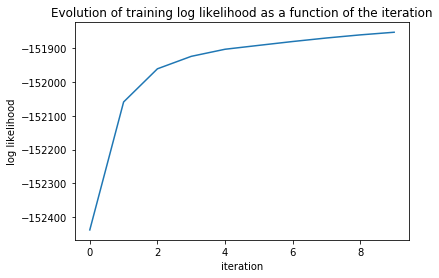

In [24]:
#IBM model 1 with EM training
            
#Here we initialize all counts to 0
co_occurences = defaultdict(lambda: defaultdict(int)) #this will be a dictionary of co-occurence counts
counts_e = defaultdict(int) #this will be a dictionary of individual counts of e
s_total = defaultdict(int)
likelihood_list = []

num_iterations = 10

#while not converged 
for k in range(num_iterations):
    print("this is iteration",k)
    co_occurences = defaultdict(lambda: defaultdict(int)) #this will be a dictionary of co-occurence counts
    counts_e = defaultdict(int) #this will be a dictionary of individual counts of e
#     s_total = defaultdict(int)
    
    for sent in range(no_sentences):
        
        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]
        
        #E-step: compute expected counts
        
        #Compute normalization term (Z or s_total)
        for word_f in sent_f:
            s_total[word_f.lower()] = 0
            for word_e in sent_e:
                s_total[word_f.lower()] += t[word_f.lower()][word_e.lower()]
        
#         #Collect counts
        for word_e in sent_e:
            for word_f in sent_f:
                #increment count of aligments by expected count
                co_occurences[word_f.lower()][word_e.lower()] += t[word_f.lower()][word_e.lower()] / s_total[word_f.lower()]
                #increment marginal count of French word by expected count
                counts_e[word_e.lower()] += t[word_f.lower()][word_e.lower()] / s_total[word_f.lower()]
    
        #M-step: normalize
        #Estimate probabilities 
        for word_e in sent_e:
            for word_f in sent_f:
                t[word_f.lower()][word_e.lower()] = co_occurences[word_f.lower()][word_e.lower()] / counts_e[word_e.lower()]
                
    #Compute the log likelihood
    likelihood = 0

    for sent in range(no_sentences):

        sent_e = sentences_e[sent]
        sent_f = sentences_f[sent]

        l = len(sent_e) #includes null
        m = len(sent_f)

        const = -m * np.log(l)

        sent_likelihood = 0 

        for word_f in sent_f:

            word_likelihood = 0 

            for word_e in sent_e:

                if word_likelihood == 0 or t[word_f.lower()][word_e.lower()] > word_likelihood:

                    word_likelihood = t[word_f.lower()][word_e.lower()]

            sent_likelihood += const + np.log(word_likelihood)

        likelihood += sent_likelihood
    
    print(likelihood)
    likelihood_list.append(likelihood)

    
# filename = 'transprobs_' + str(k) + '.pickle'                   
# with open(filename, 'wb') as f:
#     dill.dump(t,f)
        
#plot likelihood results    
iteration= list(range(len(likelihood_list)))

plt.plot(iteration, likelihood_list)
plt.xlabel("iteration")
plt.ylabel('log likelihood')
plt.title('Evolution of training log likelihood as a function of the iteration')
plt.savefig("EM_IBM1.png")
plt.show()



In [131]:
dev_e = 'validation/dev.e'
dev_f = 'validation/dev.f'

with open(test_e) as e:
    val_sentences_e = [null + l.split() for l in e.readlines()]
with open(test_f) as f:
    val_sentences_f = [l.split() for l in f.readlines()]

num_val_sentences = len(val_sentences_e)

In [25]:
#Decoding with IBM model 1
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest t

def write_naacl(filename):

    naaclfile = open(filename,"w") 

    for sent in range(num_val_sentences):
        sent_e = val_sentences_e[sent]
        sent_f = val_sentences_f[sent]


        l = len(sent_e) #includes null
        m = len(sent_f)

        for f in range(m):
            
            best_prob = 0
            best_j = 0
            
            for e in range(l):
                if t[sent_f[f].lower()][sent_e[e].lower()] > best_prob:
                    best_prob = t[sent_f[f].lower()][sent_e[e].lower()]
                    best_j = e
            
            #we ignore the NULL in decoding
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(f+1) + " S" + "\n")
    naaclfile.close()


In [138]:
test_e = 'testing/test/test.e'
test_f = 'testing/test/test.f'

with open(test_e) as e:
    test_sentences_e = [null + l.split() for l in e.readlines()]
with open(test_f) as f:
    test_sentences_f = [l.split() for l in f.readlines()]

num_test_sentences = len(test_sentences_e)
print(num_test_sentences)

447


In [143]:
#Decoding with IBM model 1
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest t

def write_test_naacl(filename):

    naaclfile = open(filename,"w") 

    for sent in range(num_test_sentences):
        sent_e = test_sentences_e[sent]
        sent_f = test_sentences_f[sent]


        l = len(sent_e) #includes null
        m = len(sent_f)

        for f in range(m):
            best_prob = 0
            best_j = 0
            for e in range(l):
                if t[sent_f[f].lower()][sent_e[e].lower()] > best_prob:
                    best_prob = t[sent_f[f].lower()][sent_e[e].lower()]
                    best_j = e
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(f+1) + " S" + "\n")

    naaclfile.close()
